# Polscope with phase reconstruction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift, ifftshift

import pickle
import waveorder as wo
import itertools


%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.style.use(['dark_background']) # Plotting option for dark background


### Load data

In [2]:
# Load simulations

f = open('simulation_data_phase_1_noise_scanned.pckl', 'rb')
I_meas, lambda_illu, n_media, ps, NA_obj, NA_illu, z_defocus, Source, chi = pickle.load(f)
f.close()
I_meas = I_meas[1:]



### Stokes vector/Polarization reconstruction

In [3]:
_, N, M, _ = I_meas.shape
cali        = False               
bg_option   = 'global'
A_matrix = np.array([[0.25, 0.25, 0],
                     [0.25, 0, 0.25],
                     [0.25, -0.25, 0],
                     [0.25, 0, -0.25]])

setup = wo.waveorder_microscopy((N,M), lambda_illu, ps, NA_obj, NA_illu, z_defocus, n_media=n_media, 
                                A_matrix=A_matrix, inc_recon='geometric', illu_mode='Arbitrary', Source=Source)
S_image_recon = setup.Stokes_recon(I_meas)
S_image_tm = setup.Stokes_transform(S_image_recon)
Recon_para =setup.Polarization_recon(S_image_tm)

In [4]:
wo.parallel_4D_viewer(np.transpose(S_image_tm,(3,0,1,2)), num_col=2, size=5)

interactive(children=(IntSlider(value=0, description='stack_idx', max=8), Output()), _dom_classes=('widget-int…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

In [5]:
wo.parallel_4D_viewer(np.transpose(Recon_para,(3,0,1,2)), num_col=2, size=5)

interactive(children=(IntSlider(value=0, description='stack_idx', max=8), Output()), _dom_classes=('widget-int…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

In [6]:
wo.image_stack_viewer(np.transpose(Recon_para[0,:,:,:],(2,0,1)))

interactive(children=(IntSlider(value=0, description='stack_idx', max=8), Output()), _dom_classes=('widget-int…

<function waveorder.visual.image_stack_viewer.<locals>.interact_plot_3D(stack_idx)>

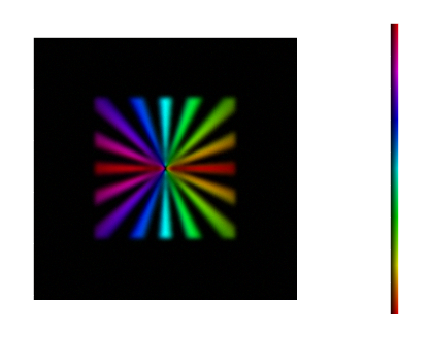

In [7]:
wo.plot_hsv([Recon_para[1,:,:,-1], Recon_para[0,:,:,-1]])

### Inclination reconstruction

### Sum of source geometric model

In [8]:

setup = wo.waveorder_microscopy((N,M), lambda_illu, ps, NA_obj, NA_illu, z_defocus, n_media=n_media, 
                                A_matrix=A_matrix, inc_recon='geometric', illu_mode='Arbitrary', Source=Source)

inc_angle, retardance_ap, inc_coeff = setup.Inclination_recon_geometric(Recon_para[0,:,:,:], Recon_para[1,:,:,:], on_axis_idx=-1)

In [9]:
np.round(setup.geometric_inc_matrix,2)

array([[ 1.  ,  0.43, -0.22, -0.09, -0.02, -0.02],
       [ 1.  ,  0.43, -0.09, -0.22,  0.02, -0.02],
       [ 1.  ,  0.43,  0.09, -0.22,  0.02,  0.02],
       [ 1.  ,  0.43,  0.22, -0.09, -0.02,  0.02],
       [ 1.  ,  0.43,  0.22,  0.09, -0.02, -0.02],
       [ 1.  ,  0.43,  0.09,  0.22,  0.02, -0.02],
       [ 1.  ,  0.43, -0.09,  0.22,  0.02,  0.02],
       [ 1.  ,  0.43, -0.22,  0.09, -0.02,  0.02],
       [ 1.  ,  0.48, -0.  ,  0.  , -0.  , -0.  ]])

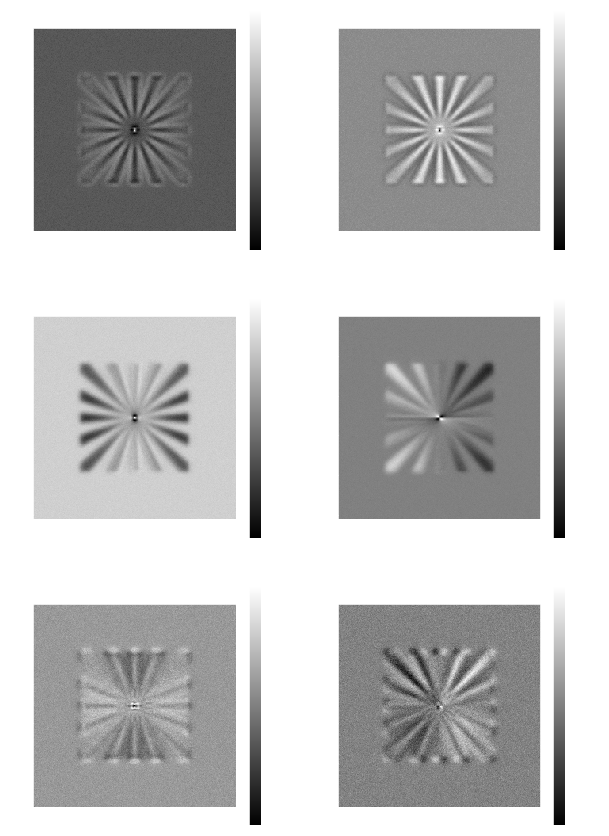

In [10]:
wo.plot_multicolumn(np.array([inc_coeff[0], inc_coeff[1], inc_coeff[2], \
                              inc_coeff[3], inc_coeff[4], inc_coeff[5]]), \
                     num_col=2, size=5)

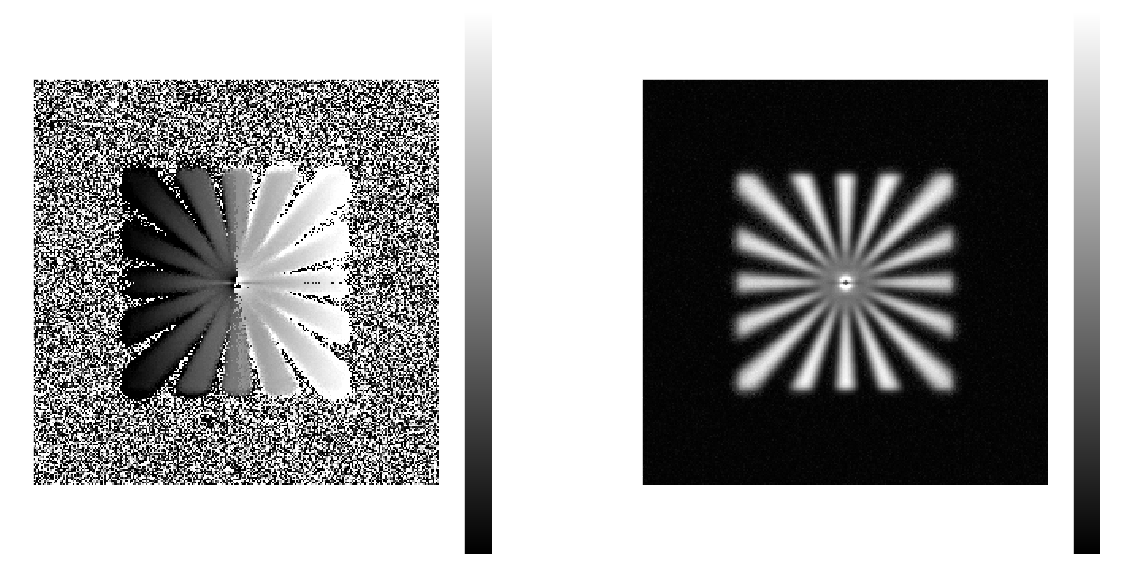

In [11]:
f1,ax = plt.subplots(1, 2, figsize=(20,10))

ax1 = ax[0].imshow(inc_angle, cmap='gray', vmin=0.8, vmax=2.3)
plt.colorbar(ax1,ax=ax[0])
ax1 = ax[1].imshow(retardance_ap, cmap='gray', vmin=0, vmax=0.6)
plt.colorbar(ax1,ax=ax[1])

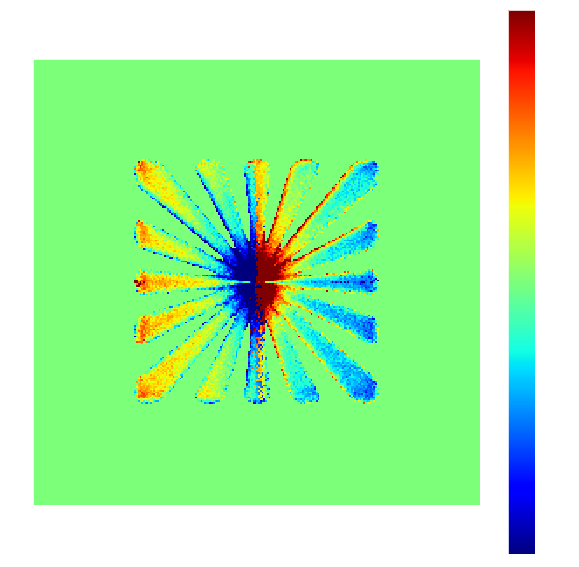

In [12]:
star, theta, xx = wo.genStarTarget(N,M)
xx = xx/np.max(xx)
inclination = ((np.pi/2 * xx) + np.pi/2)
mask = np.zeros_like(star)
mask[star>0.2] = 1

plt.figure(figsize=(10,10))
plt.imshow(mask*(inc_angle-inclination), cmap='jet',vmin=-0.2,vmax=0.2)
plt.colorbar()

### Linearized diffraction model for inclination retrieval

In [13]:
setup = wo.waveorder_microscopy((N,M), lambda_illu, ps, NA_obj, NA_illu, z_defocus, n_media=n_media, 
                                A_matrix=A_matrix, inc_recon='linear-diffraction-pinv', illu_mode='Arbitrary', Source=Source)




In [14]:

wo.parallel_4D_viewer(np.transpose(fftshift(np.concatenate((np.real(setup.H_OTF_inc[::2]), np.imag(setup.H_OTF_inc[1::2])),axis=0),axes=(1,2)),(3,0,1,2)), num_col=6, size=4)

interactive(children=(IntSlider(value=0, description='stack_idx', max=8), Output()), _dom_classes=('widget-int…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

In [15]:
wo.parallel_4D_viewer(np.real(fftshift(np.sum(setup.inc_AHA,axis=4),axes=(2,3))),num_col=12,size=2)

interactive(children=(IntSlider(value=0, description='stack_idx', max=11), Output()), _dom_classes=('widget-in…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

In [16]:
on_axis_idx = -1
reg = 1e-1*np.ones((12,))
reg[0] = 1e-3
reg[6] = 1e-3
# reg[1] = 1e-1
# reg[7] = 1e-1
reg[2:4] = 1e-2
reg[8:10] = 1e-2

S1_stack = S_image_tm[1].copy()
S2_stack = S_image_tm[2].copy()

inc_angle, retardance_ap, inc_coeff, retardance_on_axis, orientation_on_axis = setup.Inclination_recon_LD_pinv(S1_stack, S2_stack, on_axis_idx, reg=reg, reg_bire=1e-1)

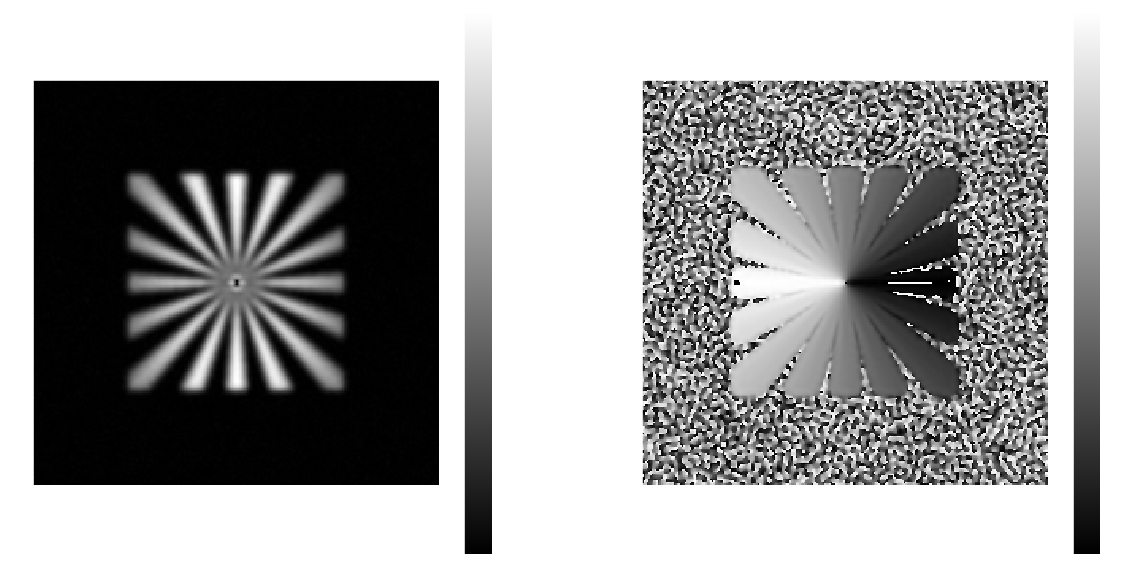

In [17]:
wo.plot_multicolumn(np.array([retardance_on_axis, orientation_on_axis%np.pi]), num_col=2, size=10, \
                    set_title=True, titles = ['Reconstructed retardance', 'Reconstructed orientation'])

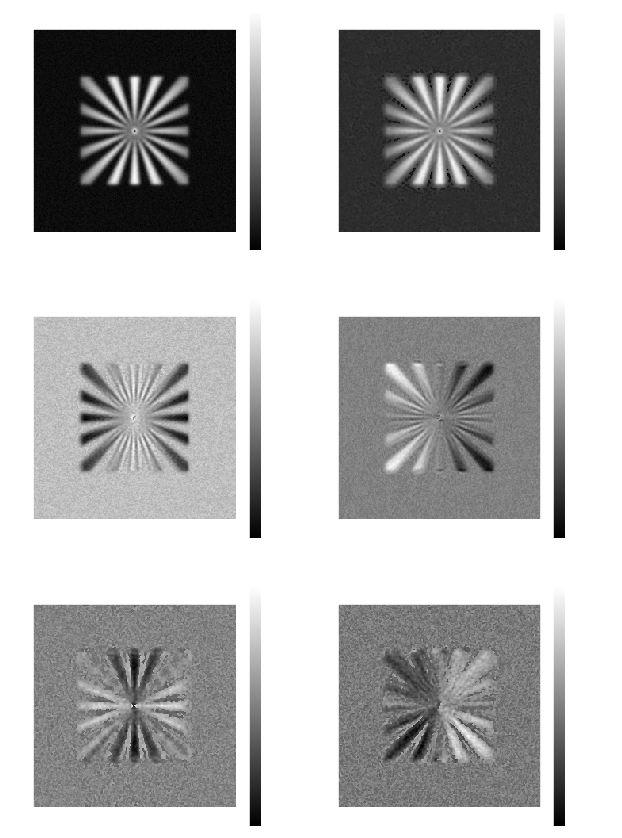

In [18]:
wo.plot_multicolumn(np.array([inc_coeff[0], inc_coeff[1], inc_coeff[2], \
                              inc_coeff[3], inc_coeff[4], inc_coeff[5]]), \
                     num_col=2, size=5)

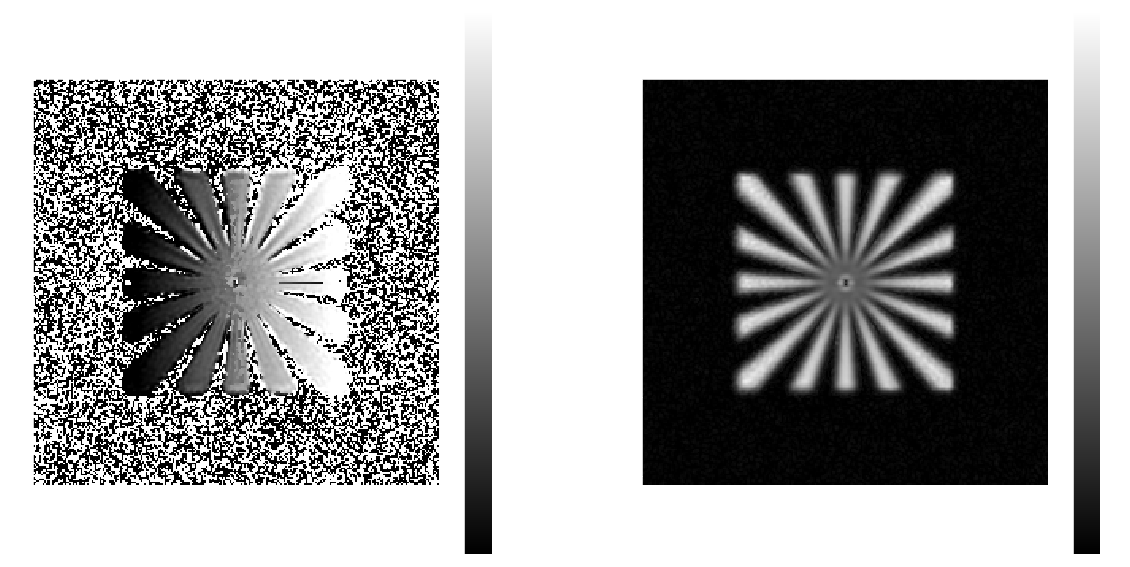

In [19]:
f1,ax = plt.subplots(1, 2, figsize=(20,10))

ax1 = ax[0].imshow(inc_angle, cmap='gray', vmin=0.8, vmax=2.3)
plt.colorbar(ax1,ax=ax[0])
ax1 = ax[1].imshow(retardance_ap, cmap='gray', vmin=0, vmax=0.6)
plt.colorbar(ax1,ax=ax[1])

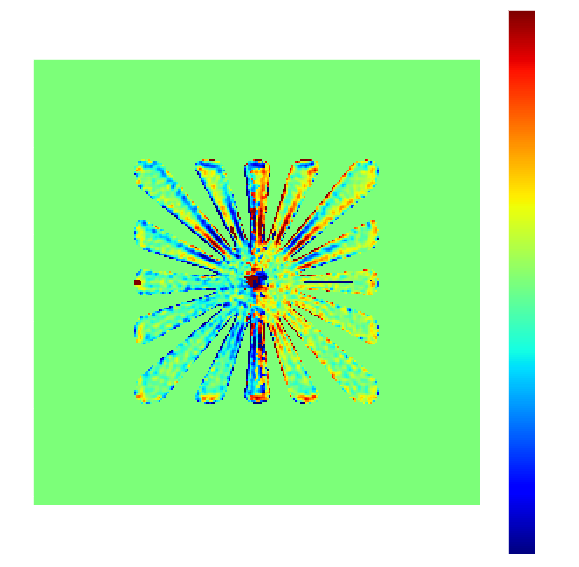

In [20]:
star, theta, xx = wo.genStarTarget(N,M)
xx = xx/np.max(xx)
inclination = ((np.pi/2 * xx) + np.pi/2)
mask = np.zeros_like(star)
mask[star>0.2] = 1

plt.figure(figsize=(10,10))
plt.imshow(mask*(inc_angle-inclination), cmap='jet',vmin=-0.2,vmax=0.2)
plt.colorbar()

### Iterative linearized diffraction model for inclination retrieval

|  100  |  4.14e+06  |   67.32   |


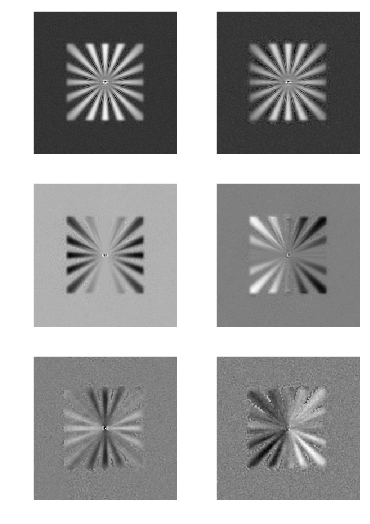

In [21]:
on_axis_idx = -1
reg = 1e-1*np.ones((12,))
reg[0] = 1e-3
reg[6] = 1e-3
# reg[1] = 1e-1
# reg[7] = 1e-1
reg[2:4] = 1e-2
reg[8:10] = 1e-2

S1_stack = S_image_tm[1].copy()
S2_stack = S_image_tm[2].copy()


inc_angle, retardance_ap, inc_coeff, inc_coeff_sin_2theta, retardance_on_axis, orientation_on_axis = \
        setup.Inclination_recon_LD_iter(S1_stack, S2_stack, on_axis_idx, reg=reg, reg_bire=1e-1, itr=100)

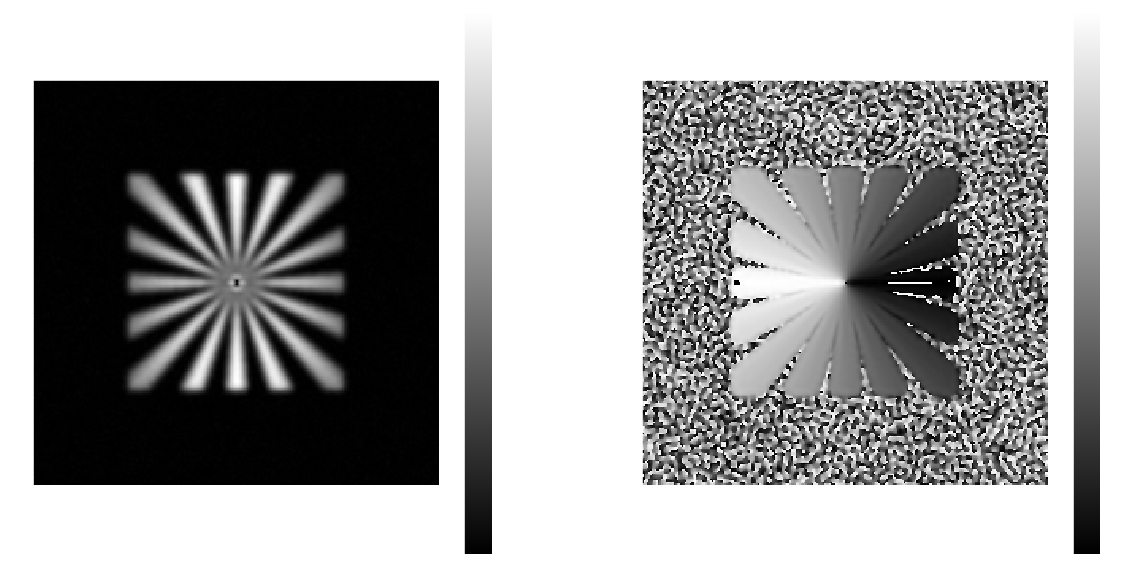

In [22]:
wo.plot_multicolumn(np.array([retardance_on_axis, orientation_on_axis%np.pi]), num_col=2, size=10, \
                    set_title=True, titles = ['Reconstructed retardance', 'Reconstructed orientation'])

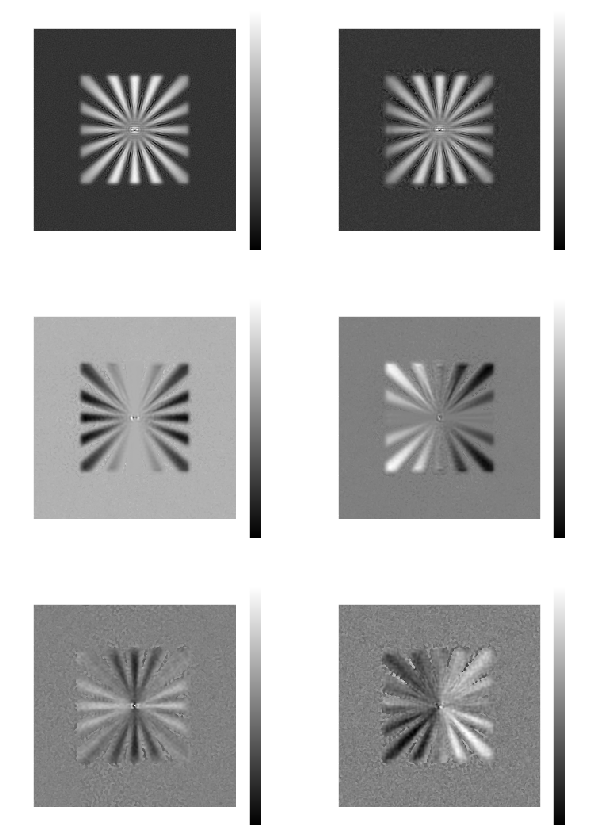

In [23]:
wo.plot_multicolumn(np.array([inc_coeff[0], inc_coeff[1], inc_coeff[2], \
                              inc_coeff[3], inc_coeff[4], inc_coeff[5]]), \
                     num_col=2, size=5)

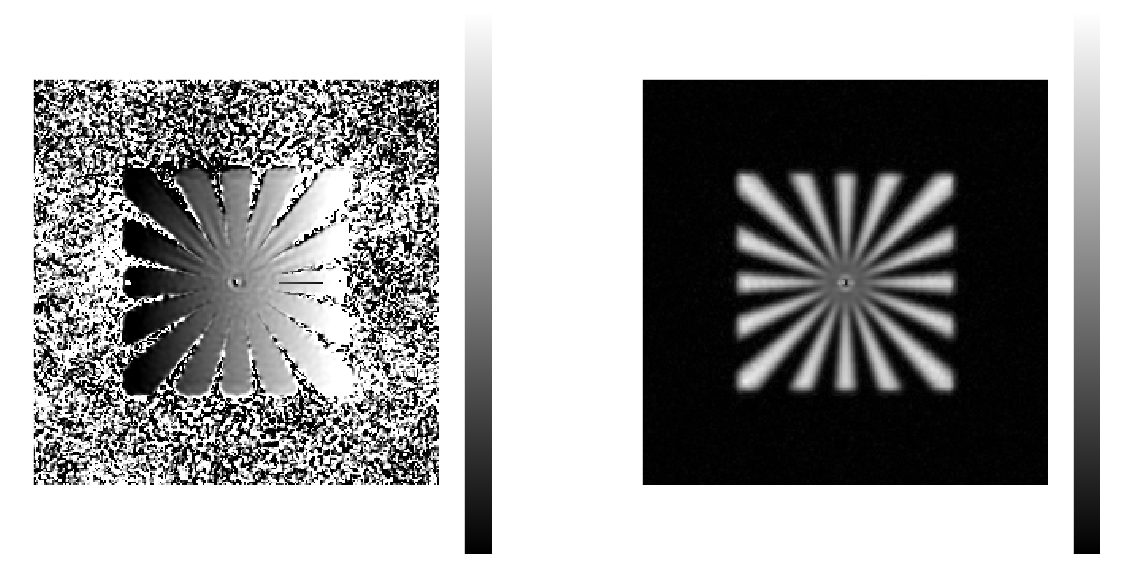

In [24]:
f1,ax = plt.subplots(1, 2, figsize=(20,10))

ax1 = ax[0].imshow(inc_angle, cmap='gray', vmin=0.8, vmax=2.3)
plt.colorbar(ax1,ax=ax[0])
ax1 = ax[1].imshow(retardance_ap, cmap='gray', vmin=0, vmax=0.6)
plt.colorbar(ax1,ax=ax[1])

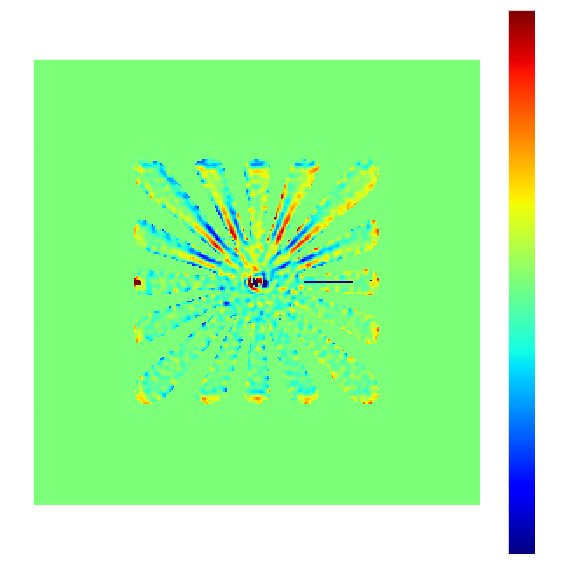

In [25]:
star, theta, xx = wo.genStarTarget(N,M)
xx = xx/np.max(xx)
inclination = ((np.pi/2 * xx) + np.pi/2)
mask = np.zeros_like(star)
mask[star>0.2] = 1

plt.figure(figsize=(10,10))
plt.imshow(mask*(inc_angle-inclination), cmap='jet',vmin=-0.2,vmax=0.2)
plt.colorbar()

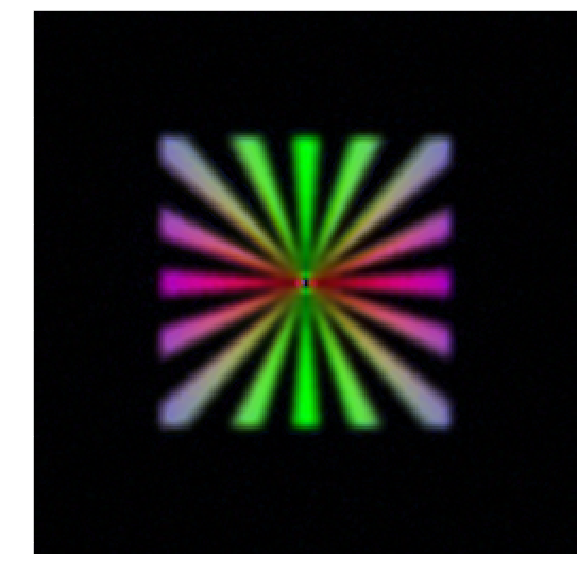

In [26]:
# Experiment 3D orientation visualization

from matplotlib.colors import hsv_to_rgb


max_ret = 2*np.pi/lambda_illu*40*1e-3

rho_norm = np.clip(retardance_ap / max_ret, 0, 1)

R_vec = np.abs(rho_norm*np.sin(inc_angle)*np.cos(orientation_on_axis))
G_vec = np.abs(rho_norm*np.sin(inc_angle)*np.sin(orientation_on_axis))
B_vec = np.abs(rho_norm*np.cos(inc_angle))


image_render = np.transpose(np.array([R_vec, G_vec, B_vec]), (1,2,0))

plt.figure(figsize=(10,10))
plt.imshow(image_render)

## Phase reconstruction with $S_0$

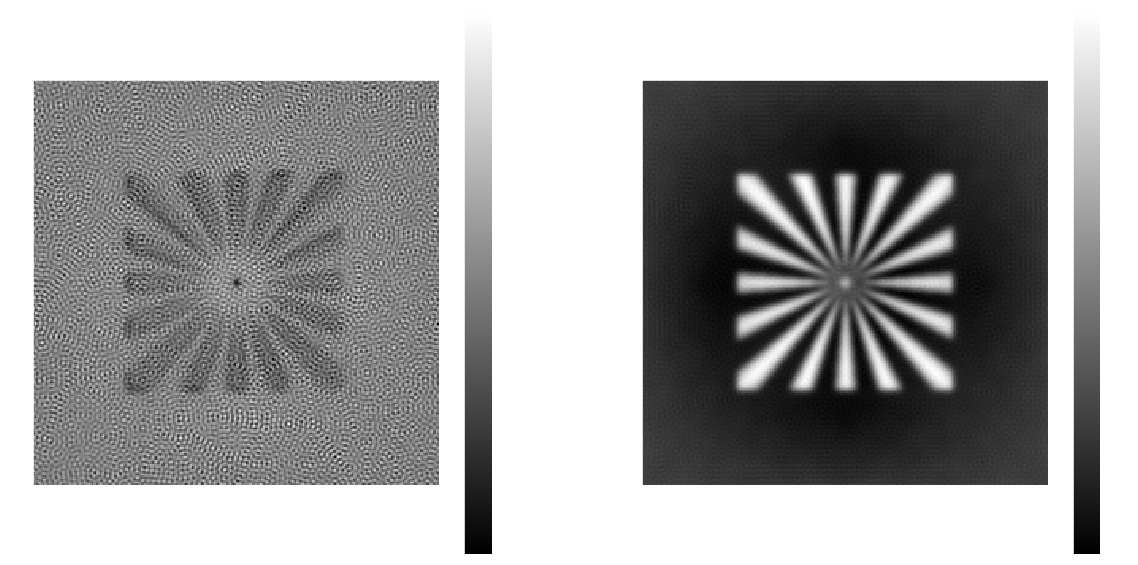

In [27]:

reg_u = 1e-3
reg_p = 1e-3
S0_stack = S_image_tm[0].copy()

mu_sample, phi_sample = setup.Phase_recon(S0_stack, method='Tikhonov', reg_u = reg_u, reg_p = reg_p)

wo.plot_multicolumn(np.array([mu_sample, phi_sample]), num_col=2, size=10, \
                    set_title=True, titles = ['Reconstructed absorption', 'Reconstructed phase'])

Number of iteration computed (1 / 50)
Number of iteration computed (2 / 50)
Number of iteration computed (3 / 50)
Number of iteration computed (4 / 50)
Number of iteration computed (5 / 50)
Number of iteration computed (6 / 50)
Number of iteration computed (7 / 50)
Number of iteration computed (8 / 50)
Number of iteration computed (9 / 50)
Number of iteration computed (10 / 50)
Number of iteration computed (11 / 50)
Number of iteration computed (12 / 50)
Number of iteration computed (13 / 50)
Number of iteration computed (14 / 50)
Number of iteration computed (15 / 50)
Number of iteration computed (16 / 50)
Number of iteration computed (17 / 50)
Number of iteration computed (18 / 50)
Number of iteration computed (19 / 50)
Number of iteration computed (20 / 50)
Number of iteration computed (21 / 50)
Number of iteration computed (22 / 50)
Number of iteration computed (23 / 50)
Number of iteration computed (24 / 50)
Number of iteration computed (25 / 50)
Number of iteration computed (26 /

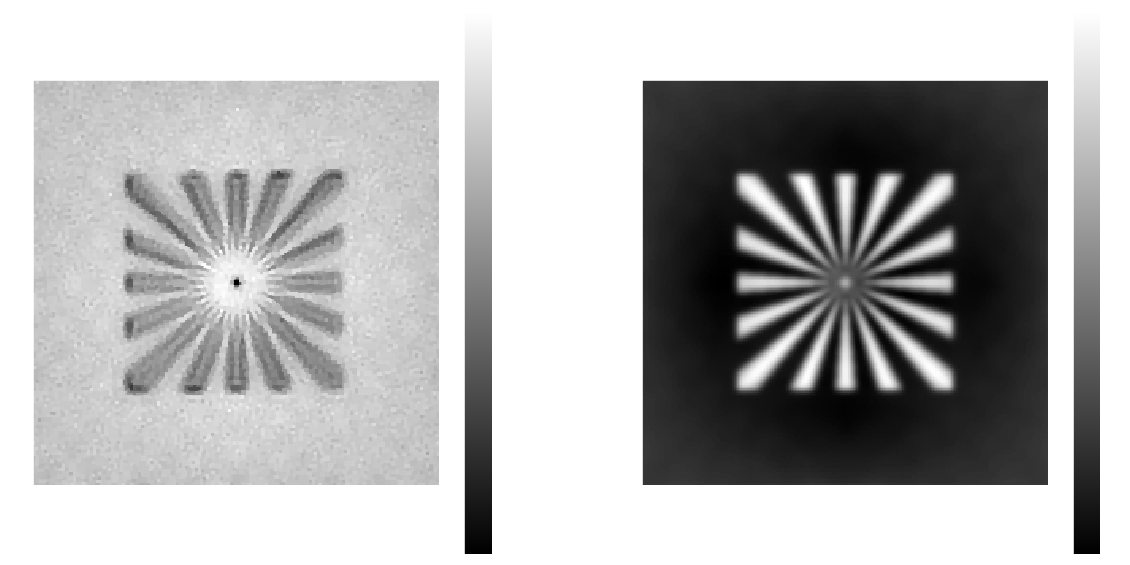

In [28]:

lambda_u = 1e-3
lambda_p = 1e-3
reg_u = 1e-5
reg_p = 1e-5

S0_stack = S_image_recon[0].copy()/np.mean(S_image_recon[0])

mu_sample_TV, phi_sample_TV = setup.Phase_recon(S0_stack, method='TV', reg_u = reg_u, reg_p = reg_p,\
                                                lambda_u = lambda_u, lambda_p = lambda_p, itr = 50, rho=1)

wo.plot_multicolumn(np.array([mu_sample_TV, phi_sample_TV]), num_col=2, size=10, \
                    set_title=True, titles = ['Reconstructed absorption', 'Reconstructed phase'])